# Correlation Coefficients
<hr style="border:2px solid black">

**load packages**

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# statistics stack
from scipy import stats

# machine learning stack
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

# miscellaneous
import warnings
warnings.simplefilter('ignore')

**load data**

In [2]:
df = sns.load_dataset('penguins')
df.dropna(inplace=True, ignore_index=True)

In [3]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


**feature variables**

In [4]:
numerical_features = [
    'bill_length_mm',
    'bill_depth_mm',
    'flipper_length_mm',
    'body_mass_g'
]

categorical_features = [
    'species',
    'island',
    'sex'
]

## correlation among numerical features

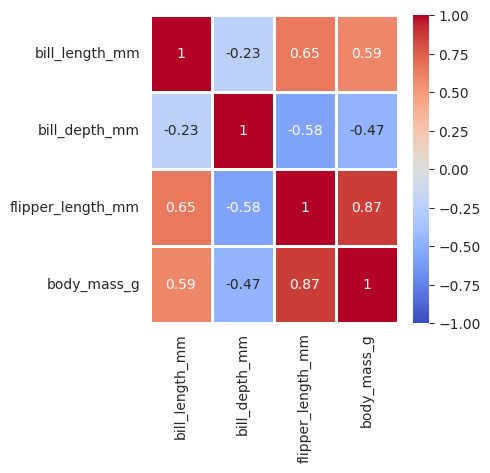

In [5]:
plt.figure(figsize=(4,4),dpi=100)
sns.heatmap(
    data=df[numerical_features].corr(),
    cmap='coolwarm',
    linecolor='white',
    linewidth=1,
    annot=True,
    vmin=-1,
    vmax=1
);

**scatter plot example**

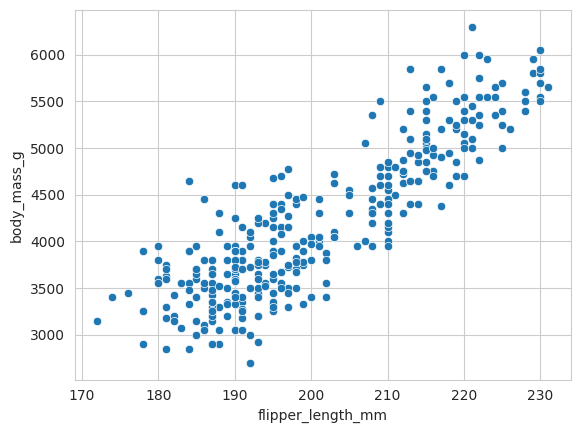

In [6]:
sns.scatterplot(
        x=df.flipper_length_mm,
        y=df.body_mass_g,
    );

## correlation among categorical features

In [7]:
def cat_cat_correlation(df_,cat_col1,cat_col2):
    """
    This function spits out Cramer's correlation statistic, with Bergsma-Wicher 
    correction, between two categorical columns of a dataframe 
    """
    crosstab = pd.crosstab(df_[cat_col1], df_[cat_col2])
    chi_sqr = stats.chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    r,k = crosstab.shape
    phi_sqr_corr = max(0, chi_sqr/n - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    
    result = np.sqrt(phi_sqr_corr / min( (k_corr-1), (r_corr-1)))
    return round(result,3)

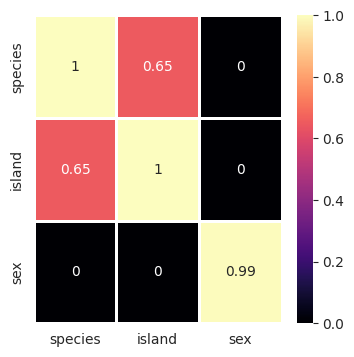

In [8]:
cramer_v_corr = dict(
    zip(
        categorical_features,
        [[cat_cat_correlation(df,f1,f2) for f2 in categorical_features] for f1 in categorical_features]
    )
)

plt.figure(figsize=(4,4),dpi=100)
sns.heatmap(data=pd.DataFrame(data=cramer_v_corr,index=categorical_features),
            cmap='magma',
            linecolor='white',
            linewidth=1,
            annot=True,
            vmin=0,
            vmax=1
           );

**bar plot example**

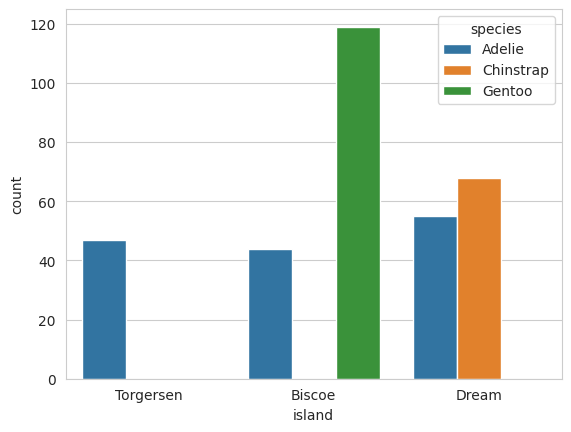

In [9]:
sns.countplot(data=df, x='island', hue='species', fill= True);

## correlation between categorical and numerical features

In [13]:
# def cat_num_correlation(df_,cat_col,num_col):
#     """
#     This function spits out a sensible correlation coefficient
#     between a categorical column and a numerical column of a dataframe.
#     The correlation is essentially the silhouette score of the numerical
#     data points with the catagorical variable values serving as cluster labels
#     """
#     data_points = df_[num_col].values.reshape(-1,1)
#     labels = LabelEncoder().fit_transform(df_[cat_col])
#     score = silhouette_score(data_points,labels)
#     score = score * np.heaviside(score,0)
#     score = round(score,3)
#     return score

In [16]:
import optbinning as op

(CVXPY) Dec 17 11:59:07 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Dec 17 11:59:07 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [17]:
def cat_num_correlation(df_,cat_col,num_col):
    """
    This function spits out a sensible correlation coefficient
    between a categorical column and a numerical column of a dataframe.
    The correlation is essentially the corrected Cramer's correlation statistic,
    after the numerical data points have been transformed under optimal binning
    """
    _df = df_.copy()
    class_number = _df[cat_col].nunique()
    binning = op.MulticlassOptimalBinning()
    _df['binned_feature'] =binning.fit_transform(_df[num_col], _df[cat_col])
    result = cat_cat_correlation(_df,cat_col,'binned_feature')
    return round(result,3)

In [18]:
cat_num_correlation(df,'species','bill_length_mm')

0.65

In [19]:
cat_num_correlation(df,'island','bill_length_mm')

0.288

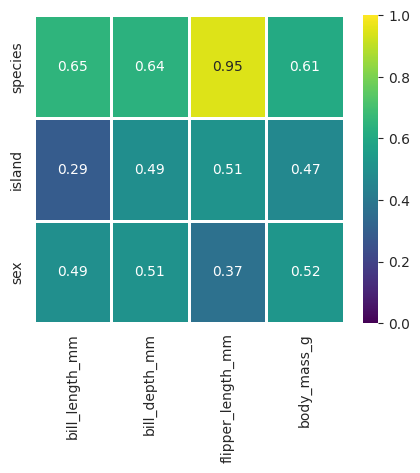

In [20]:
cat_num_corr_values = dict(
    zip(
        numerical_features,
        [[cat_num_correlation(df,f1,f2) for f1 in categorical_features] for f2 in numerical_features]
    )
)

plt.figure(figsize=(5,4),dpi=100)
sns.heatmap(data=pd.DataFrame(data=cat_num_corr_values,index=categorical_features),
            cmap='viridis',
            linecolor='white',
            linewidth=1,
            annot=True,
            vmin=0,
            vmax=1
           );

**kde plot example**

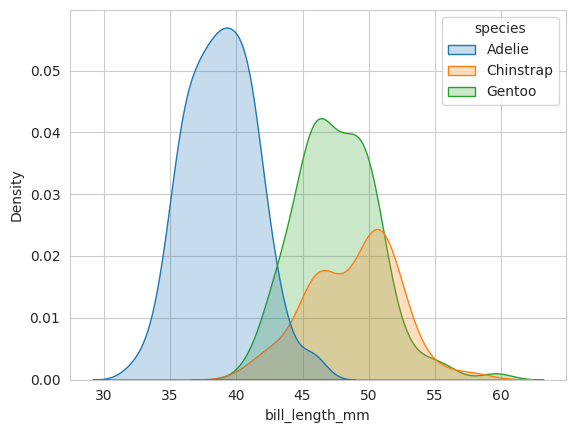

In [14]:
sns.kdeplot(data=df, x='bill_length_mm', hue='species', fill= True);

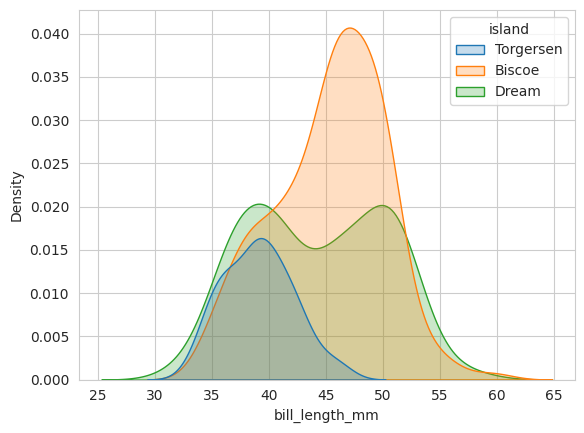

In [15]:
sns.kdeplot(data=df, x='bill_length_mm', hue='island', fill= True);

**anova p test**

In [21]:
def anova_pvalue(df_,cat_col,num_col):
    """
    This function spits out the anova p-value (probability of no correlation) 
    between a categorical column and a numerical column of a dataframe
    """
    category_group_lists = df_.groupby(cat_col)[num_col].apply(list)
    anova_results = stats.f_oneway(*category_group_lists)
    p_value = round(anova_results[1],3)
    return p_value

In [22]:
anova_pvalue(df,'sex','body_mass_g')

0.0